## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_first_batch(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = np.float32(-2)
    a3 = np.float32(3)
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_second_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_third_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = thetas[4]
    cp2 = thetas[5]
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y

### Define prior and summary stats dependent on prior

In [5]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [6]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    x = torch.arange(0,10,0.01, dtype=torch.float64)

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(13) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]   #value of min
        
        s[3] = np.nanmax(batch[x<4])   # local max
        
  
        s[4] = x[np.nanargmax(batch[x<4])]   #value of max

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[5] = np.nanmax(batch[(x>=4)&(x<8)])
            s[6] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4
            s[9] = np.nanmin(batch[(x>=4)&(x<8)])
            s[10] = x[np.nanargmin(batch[(x>=4)&(x<8)])] +4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[7] = np.nanmin(batch[x>=5])
            s[8] = x[np.nanargmin(batch[x>=5])] + 5
            
            s[11] = np.nanmax(batch[x>=5])
            s[12] = x[np.nanargmax(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [7]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

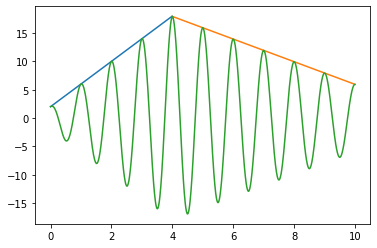

In [8]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [9]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

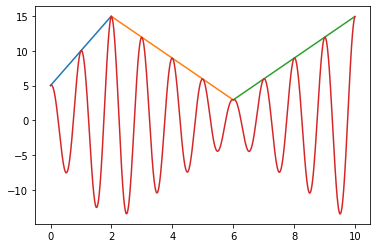

In [10]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [11]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0, -1, 3]  

prior_max = [7, 7, -1, 4, 3, 7]

num_simulations=1000

## First round

In [12]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_first_batch, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_413706/3928248213.py:58: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)
/tmp/ipykernel_413706/3928248213.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
x = extract_sumstats(x_without)

In [14]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 86 epochs.


In [15]:
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_first_batch(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([1000])
torch.Size([1, 13])


In [16]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Second round

In [17]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:4], high = prior_max[2:4])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_second_batch, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9410,  4.9677, -3.8316,  2.6509]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9959,  4.8994, -3.1691,  1.7719]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0362,  4.7304, -2.5583,  1.9015]])
tensor([-3.6177])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9170,  4.8650, -1.6027,  3.3371]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.8718,  4.9670, -1.5608,  1.1025]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.8836,  4.9513, -1.4868,  0.4798]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 4.9862,  4.7659, -2.2089,  2.3652],
        [ 4.8613,  4.9269, -1.0234,  3.4337]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0189,  4.9813, -3.5417,  3.0004]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.8935,  5.0256, -1.4644,  3.5566]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0201,  4.9003, -2.7879,  1.0412]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 2])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 4.9672,  5.0230, -4.0500,  1.2656],
        [ 4.9325,  5.0315, -2.4080,  1.5771],
        [ 4.7898,  4.8966, -2.3281,  3.0561],
        ...,
        [ 4.8245,  5.0111, -2.6777,  0.2757],
        [ 4.9930,  5.1335, -3.7645,  3.2747],
        [ 4.8163,  4.9876, -2.1307,  3.0271]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 61 epochs.


In [19]:
obs_real = piecewise_linear_second_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Third and last round

In [20]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[4:6], high = prior_max[4:6])


prior_combined2 = Combined(proposal2, prior3, number_params_1=4)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_third_batch, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.1011,  4.9991, -3.1511,  2.1795,  2.5626,  6.5446]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9527,  5.0982, -3.0377,  2.1849,  1.1557,  3.4631]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0802,  4.8876, -2.9850,  2.2733, -0.7346,  6.0427]])
tensor([0.8476])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9688,  4.9125, -2.9830,  2.4118,  1.7538,  4.9061]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9453,  4.9823, -3.0697,  2.2623,  0.2277,  4.5770]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9340,  4.9911, -2.8159,  2.5139,  1.2744,  5.3436]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 4])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 4.9591,  5.1812, -3.0560,  2.1428, -0.6027,  3.8981],
        [ 4.7674,  4.8954, -2.9686,  1.9304,  2.5796,  5.4355]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.0439,  4.9647, -3.0193,  1.6481,  0.1429,  4.1946]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0380,  4.9508, -3.0469,  2.5403, -0.3774,  3.2278]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.0980,  4.9435, -3.0326,  2.3079,  1.6444,  4.4797]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 4])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 5.1444,  4.9487, -3.0914,  2.2620,  1.2090,  5.1247],
        [ 4.8958,  4.9625, -2.9174,  2.1788,  0.4816,  6.4860],
        [ 4.9799,  4.9428, -2.9590,  2.3199, -0.3899,  3.0470],
        ...,
        [ 4.9933,  5.0324, -3.1538,  2.2801, -0.8323,  6.8604],
        [ 4.9660,  5.0080, -3.1197,  2.3542,  2.6435,  6.5228],
        [ 4.9505,  5.0328, -3.1126,  2.3150,  2.4148,  4.0898]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 78 epochs.


In [22]:
obs_real = piecewise_linear_third_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


samples = posterior3.sample((num_samples,), x=obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

(-10.0, 30.0)

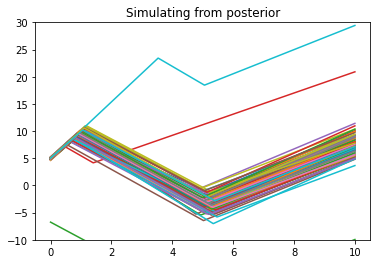

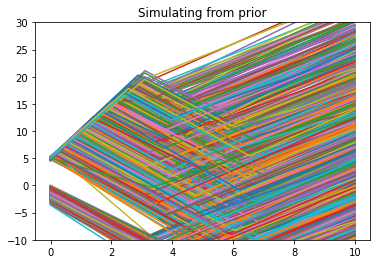

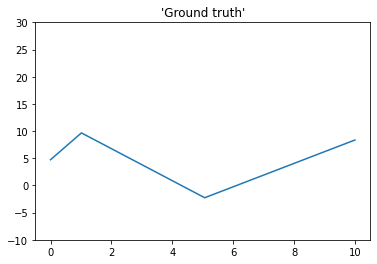

In [27]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_third_batch)(sample) for sample in samples)



fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s)
    plt.ylim(-10,30)
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x in x_without:
    im = plt.plot(x_lin, x)
    plt.ylim(-10,30)
    
    
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_third_batch(true_params)




fig, ax = plt.subplots(1, 1)
ax.set_title("'Ground truth'")
plt.plot(x_lin, obs_real)
plt.ylim(-10,30)


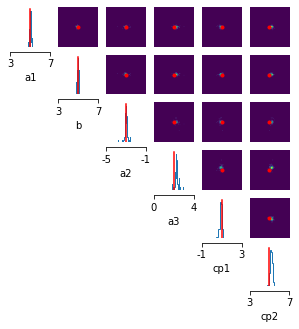

In [28]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3', 'cp1', 'cp2' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)